In [0]:
import rasterio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [0]:
print('Landsat on Google:')
filepath = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/LC08_L1TP_042034_20170616_20170629_01_T1_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)

Landsat on Google:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7821, 'height': 7951, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 204285.0,
       0.0, -30.0, 4268115.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [0]:
print('Landsat on AWS:')
filepath = 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/040/037/LC08_L1TP_040037_20180301_20180301_01_RT/LC08_L1TP_040037_20180301_20180301_01_RT_B4.TIF'
with rasterio.open(filepath) as src:
    print(src.profile)  

Landsat on AWS:
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7681, 'height': 7821, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 370185.0,
       0.0, -30.0, 3787815.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Decimation factor= 9


Text(0, 0.5, 'Row #')

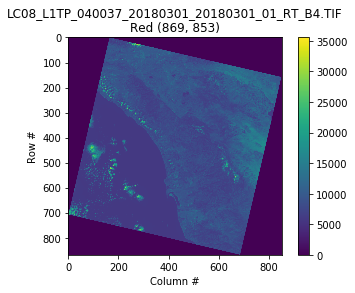

In [0]:
# Use the same example image:
date = '2018-03-01'
#url = 'http://landsat-pds.s3.amazonaws.com/c1/L8/042/034/LC08_L1TP_042034_20170616_20170629_01_T1/'
#redband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(4)
#nirband = 'LC08_L1TP_042034_20170616_20170629_01_T1_B{}.TIF'.format(5)
url = 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/040/037/LC08_L1TP_040037_20180301_20180301_01_RT/'
redband = 'LC08_L1TP_040037_20180301_20180301_01_RT_B{}.TIF'.format(4)
nirband = 'LC08_L1TP_040037_20180301_20180301_01_RT_B{}.TIF'.format(5)

with rasterio.open(url+redband) as src:
    profile = src.profile
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    print('Decimation factor= {}'.format(oview))
    red = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(red)
plt.colorbar()
plt.title('{}\nRed {}'.format(redband, red.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

Text(0, 0.5, 'Row #')

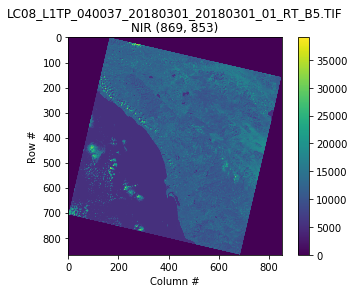

In [0]:
with rasterio.open(url+nirband) as src:
    oviews = src.overviews(1) # list of overviews from biggest to smallest
    oview = oviews[1]  # Use second-highest resolution overview
    nir = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

plt.imshow(nir)
plt.colorbar()
plt.title('{}\nNIR {}'.format(nirband, nir.shape))
plt.xlabel('Column #')
plt.ylabel('Row #')

/Users/shalu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/Users/shalu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, 'Row #')

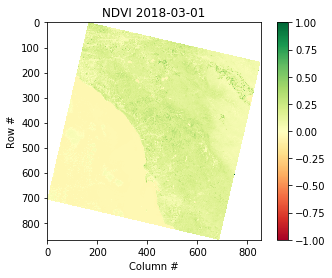

In [0]:
def calc_ndvi(nir,red):
    '''Calculate NDVI from integer arrays'''
    nir = nir.astype('f4')
    red = red.astype('f4')
    ndvi = (nir - red) / (nir + red)
    return ndvi

ndvi = calc_ndvi(nir,red)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [0]:
localname = 'LC08_L1TP_042034_20180301_20180301_01_RT_NDVI_OVIEW.tif'

with rasterio.open(url+nirband) as src:
    profile = src.profile.copy()

    aff = src.transform
    newaff = rasterio.Affine(aff.a * oview, aff.b, aff.c,
                             aff.d, aff.e * oview, aff.f)
    profile.update({
            'dtype': 'float32',
            'height': ndvi.shape[0],
            'width': ndvi.shape[1],
            'transform': newaff})  

    with rasterio.open(localname, 'w', **profile) as dst:
        dst.write_band(1, ndvi)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 853, 'height': 869, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(270.0, 0.0, 370185.0,
       0.0, -270.0, 3787815.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


Text(0, 0.5, 'Row #')

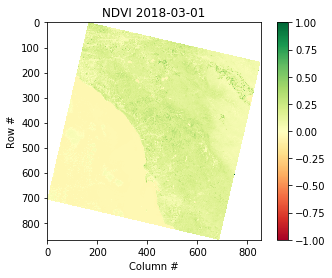

In [0]:
# Reopen the file and plot
with rasterio.open(localname) as src:
    print(src.profile)
    ndvi = src.read(1) # read the entire array

plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()
plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

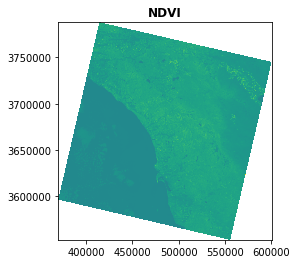

In [0]:
# in this case, coordinates are Easting [m] and Northing [m], and colorbar is default instead of RdYlGn
with rasterio.open(localname) as src:
    fig, ax = plt.subplots()
    rasterio.plot.show(src, ax=ax, title='NDVI')

In [0]:
with rasterio.open(localname) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='epsg:4326')

    lon,lat = (-117.16, 32.72)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    print('Fresno NDVI\n-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')

    # What is the NDVI?
    value = ndvi[row, col]
    print(f'ndvi=\t\t\t{value:.2f}')


    # Or if you see an interesting feature and want to know the spatial coordinates:
    row, col = 700, 400
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(utm, lonlat, east, north)
    value = ndvi[row, col]
    print(f'''
Interesting Feature
-------
row,col=          ({row},{col})
easting,northing= ({east:g},{north:g})
lon,lat=          ({lon:.2f},{lat:.2f})
ndvi=              {value:.2f}
''')

Fresno NDVI
-------
lon,lat=		(-117.16,32.72)
easting,northing=	(485006,3.62026e+06)
row,col=		(620,425)
ndvi=			0.03

Interesting Feature
-------
row,col=          (700,400)
easting,northing= (478320,3.59868e+06)
lon,lat=          (-117.23,32.53)
ndvi=              -0.05



In [0]:
import pyproj
with rasterio.open(localname) as src:
    # Use pyproj to convert point coordinates
    utm = pyproj.Proj(src.crs) # Pass CRS of image from rasterio
    lonlat = pyproj.Proj(init='EPSG:6426')

    lon,lat = (-118.39943, 32.10779)
    east,north = pyproj.transform(lonlat, utm, lon, lat)

    print('San Diego NDVI\n-------')
    print(f'lon,lat=\t\t({lon:.2f},{lat:.2f})')
    print(f'easting,northing=\t({east:g},{north:g})')

    # What is the corresponding row and column in our image?
    row, col = src.index(east, north) # spatial --> image coordinates
    print(f'row,col=\t\t({row},{col})')

    # What is the NDVI?
    value = ndvi[row, col]
    print(f'ndvi=\t\t\t{value:.2f}')

'''
    # Or if you see an interesting feature and want to know the spatial coordinates:
    row, col = 200, 450
    east, north = src.xy(row,col) # image --> spatial coordinates
    lon,lat = pyproj.transform(utm, lonlat, east, north)
    value = ndvi[row, col]
'''

San Diego NDVI
-------
lon,lat=		(-118.40,32.11)
easting,northing=	(-1.44267e+06,3.01554e+06)
row,col=		(2860,-6718)


IndexError: index 2860 is out of bounds for axis 0 with size 869

In [0]:
#Second set of data
url = 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/040/037/LC08_L1TP_040037_20180723_20180731_01_T1/'
redband2 = 'LC08_L1TP_040037_20180723_20180731_01_T1_B{}.TIF'.format(4)
nirband2 = 'LC08_L1TP_040037_20180723_20180731_01_T1_B{}.TIF'.format(5)
thermalband2 = 'LC08_L1TP_040037_20180723_20180731_01_T1_B{}.TIF'.format(10)
swirband2 = 'LC08_L1TP_040037_20180723_20180731_01_T1_B{}.TIF'.format(6)

red2 = getband(url, redband2)

nir2 = getband(url, nirband2)

therm2 = getband(url, thermalband2)
swir2 = getband(url, swirband2)

Decimation factor= 9
Decimation factor= 9
Decimation factor= 9
Decimation factor= 9


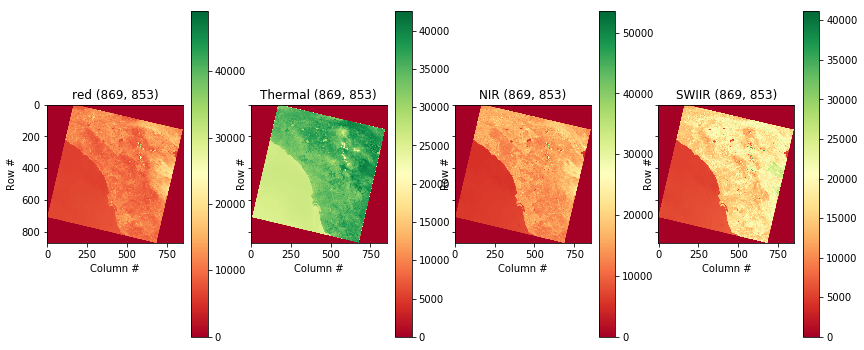

In [0]:
fig, axes = plt.subplots(1,4, figsize=(14,6), sharex=True, sharey=True)
plotband("red",band=red2, axis=axes[0])
plotband("Thermal", band=therm2, axis=axes[1])
plotband("NIR", band=nir2, axis=axes[2])
plotband("SWIIR", band=swir2, axis=axes[3])

ValueError: operands could not be broadcast together with shapes (869,853) (869,854) 

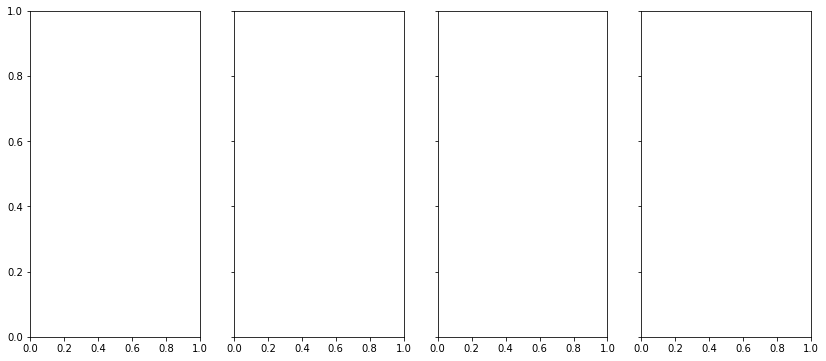

In [0]:
fig, axes = plt.subplots(1,4, figsize=(14,6), sharex=True, sharey=True)
plotband("red",band=red2-red, axis=axes[0])
plotband("Thermal", band=therm2-therm, axis=axes[1])
plotband("NIR", band=nir2-nir, axis=axes[2])
plotband("SWIR", band=swir2-swir, axis=axes[3])

In [0]:
ndvi2 = calc_ndvi(nir2,red2)
plt.imshow(ndvi2-ndvi, cmap='RdYlGn')
plt.colorbar()
#plt.title('NDVI {}'.format(date))
plt.xlabel('Column #')
plt.ylabel('Row #')

In [0]:
#3rd set
url = 'https://s3-us-west-2.amazonaws.com/landsat-pds/c1/L8/139/207/LC08_L1GT_139207_20180814_20180814_01_RT/'
redband3 = 'LC08_L1GT_139207_20180814_20180814_01_RT_B{}.TIF'.format(4)
nirband3 = 'LC08_L1GT_139207_20180814_20180814_01_RT_B{}.TIF'.format(5)
thermalband3 = 'LC08_L1GT_139207_20180814_20180814_01_RT_B{}.TIF'.format(10)
swirband3 = 'LC08_L1GT_139207_20180814_20180814_01_RT_B{}.TIF'.format(6)

red3 = getband(url, redband3)

nir3 = getband(url, nirband3)

therm3 = getband(url, thermalband3)
swir3 = getband(url, swirband3)

In [0]:
fig, axes = plt.subplots(1,4, figsize=(14,6), sharex=True, sharey=True)
plotband("red",band=red3, axis=axes[0])
plotband("Thermal", band=therm3, axis=axes[1])
plotband("NIR", band=nir3, axis=axes[2])
plotband("SWIIR", band=swir3, axis=axes[3])